The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


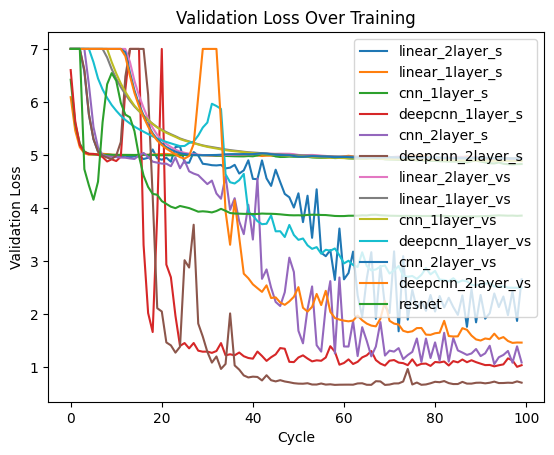

In [19]:
import torch
import matplotlib.pyplot as plt
from models import *
from helpersGeneration import *
from helpersPlot import *
import pandas as pd

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


# Load training results
results = torch.load("training_results.pth")

# Extract data
validation_losses = results["validation_losses"]
all_labels = results["all_labels"]
model_weights = results["model_weights"]

# Example: Plot validation loss curves
for model_name, losses in validation_losses.items():
    plt.plot(np.clip(losses["val_avg"],0,7), label=model_name)

plt.xlabel("Cycle")
plt.ylabel("Validation Loss")
plt.legend()
plt.title("Validation Loss Over Training")
plt.show()


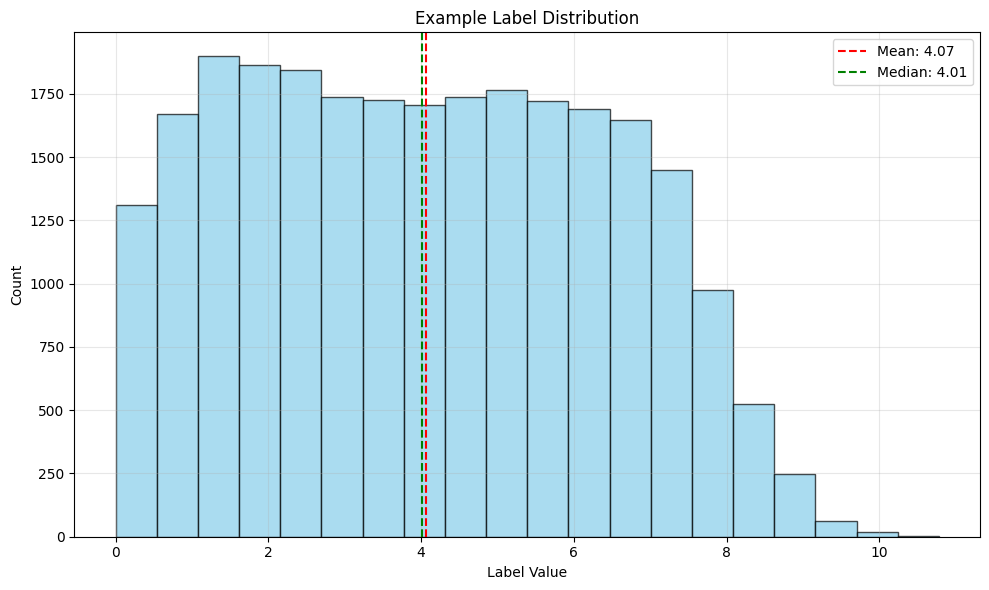

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_labels_histogram(labels_array, bins=10, title="Distribution of Labels", 
                          xlabel="Value", ylabel="Frequency", 
                          color='skyblue', edgecolor='black',
                          figsize=(10, 6), show_grid=True, 
                          show_mean=True, show_median=True):

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot histogram
    ax.hist(labels_array, bins=bins, color=color, edgecolor=edgecolor, alpha=0.7)
    
    # Add mean line if requested
    if show_mean and len(labels_array) > 0:
        mean_value = np.mean(labels_array)
        ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5, 
                  label=f'Mean: {mean_value:.2f}')
    
    # Add median line if requested
    if show_median and len(labels_array) > 0:
        median_value = np.median(labels_array)
        ax.axvline(median_value, color='green', linestyle='dashed', linewidth=1.5,
                  label=f'Median: {median_value:.2f}')
    
    # Add labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    # Add grid
    if show_grid:
        ax.grid(alpha=0.3)
    
    # Add legend if we have mean or median
    if (show_mean or show_median) and len(labels_array) > 0:
        ax.legend()
    
    plt.tight_layout()
    
    return fig, ax

# Plot histogram
fig, ax = plot_labels_histogram(
                all_labels, 
                bins=20,
                title="Example Label Distribution",
                xlabel="Label Value",
                ylabel="Count"
                )

plt.show()

In [22]:
from trainSettings import *

models, optimizers, schedulers = getTrainingModels()

# Load model weights
for name, model in models.items():
    if name in model_weights:
        model.load_state_dict(model_weights[name])
        model.eval()  # Set to evaluation mode
        print(f"Loaded weights for {name}")
    else:
        print(f"Warning: No saved weights found for {name}")



Loaded weights for linear_2layer_s
Loaded weights for linear_1layer_s
Loaded weights for cnn_1layer_s
Loaded weights for deepcnn_1layer_s
Loaded weights for cnn_2layer_s
Loaded weights for deepcnn_2layer_s
Loaded weights for linear_2layer_vs
Loaded weights for linear_1layer_vs
Loaded weights for cnn_1layer_vs
Loaded weights for deepcnn_1layer_vs
Loaded weights for cnn_2layer_vs
Loaded weights for deepcnn_2layer_vs
Loaded weights for resnet


In [23]:
# Load validation dataset (fixed, does not change across cycles)
val_videos = load_validation_data(length=30)  # Returns (vid1, vid3, vid5, vid7)
val_labels = torch.tensor([1, 3, 5, 7], dtype=torch.float32)  # Corresponding labels

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_predictions_violin(models, val_videos, val_labels, chosen_label):
    """
    Plots a violin plot of the predictions of all models for a specific validation dataset.

    Args:
    - models (dict): Dictionary of model names and instances.
    - val_videos (tuple): Tuple of validation video tensors.
    - val_labels (Tensor): Corresponding labels (torch.Tensor([1, 3, 5, 7])).
    - chosen_label (int): The validation label to visualize (must be 1, 3, 5, or 7).
    """

    # Find index of the chosen label
    if chosen_label not in val_labels.tolist():
        print(f"Error: Chosen label {chosen_label} not in available labels {val_labels.tolist()}")
        return

    label_idx = val_labels.tolist().index(chosen_label)
    chosen_video = val_videos[label_idx]  # Get corresponding video

    predictions = {}

    # Compute predictions for each model
    for name, model in models.items():
        model.eval()
        with torch.no_grad():
            preds = model(chosen_video).mean(dim=1).squeeze().tolist()  # Get all predictions for this video
            predictions[name] = preds  # Store as list

    # Prepare data for Seaborn
    data = []
    for model_name, preds in predictions.items():
        for pred in preds:
            data.append({"Model": model_name, "Prediction": pred})

    # Convert to DataFrame for easy plotting
    df = pd.DataFrame(data)

    # Plot violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Model", y="Prediction", data=df, inner="box", hue="Model", palette="coolwarm")

    # Add reference line for true label
    plt.axhline(y=chosen_label, color='r', linestyle='--', label=f"True Value: {chosen_label}")

    plt.xlabel("Model")
    plt.ylabel("Predicted Value")
    plt.title(f"Distribution of Model Predictions for Validation Set {chosen_label}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()



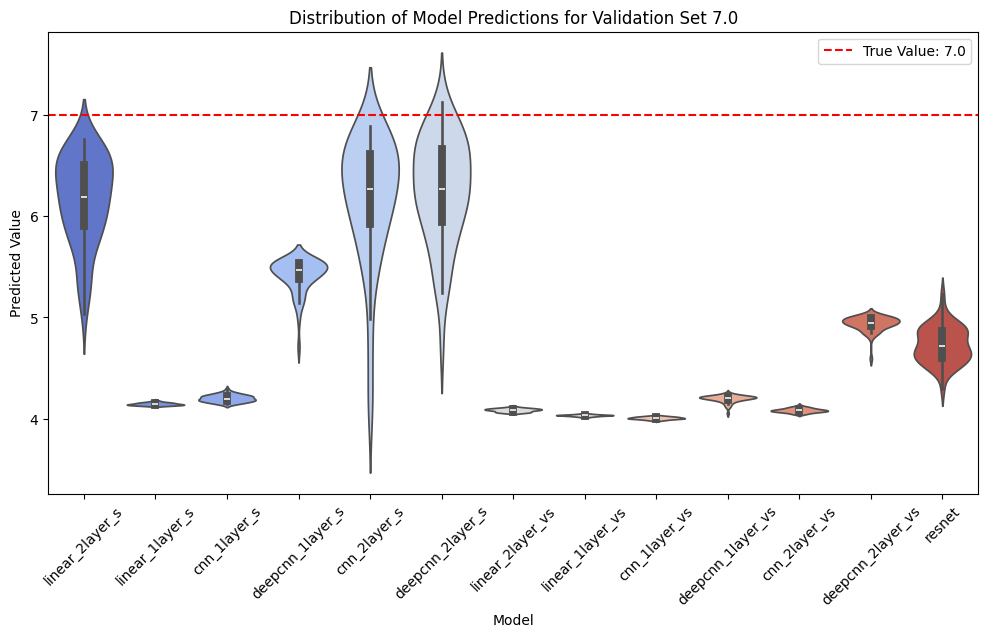

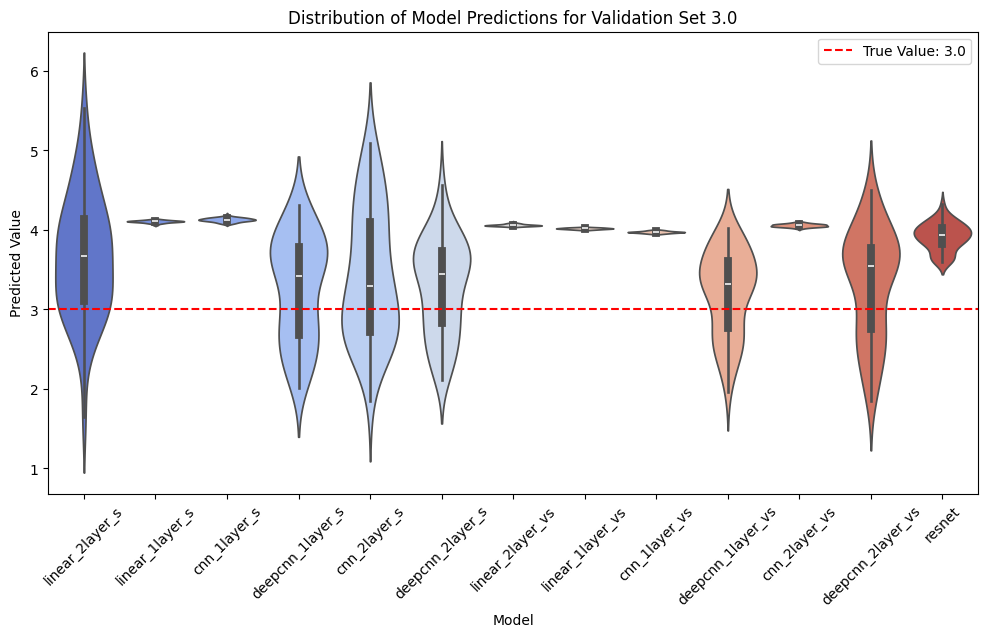

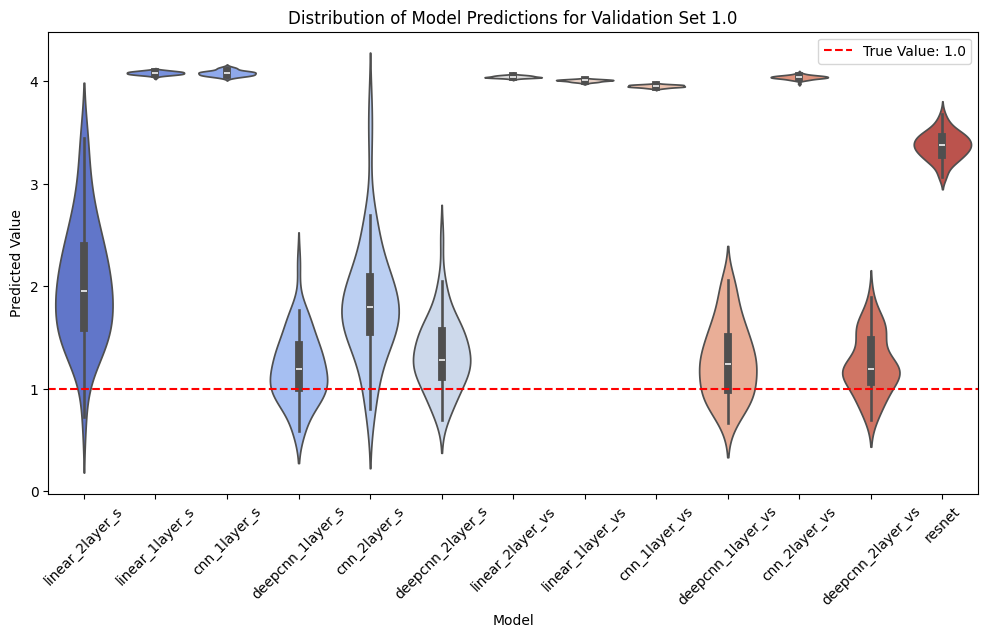

In [ ]:

plot_model_predictions_violin(models, val_videos, val_labels, chosen_label=7.0)
plot_model_predictions_violin(models, val_videos, val_labels, chosen_label=3.0)
plot_model_predictions_violin(models, val_videos, val_labels, chosen_label=1.0)

In [56]:
def plot_model_predictions_average(models, val_videos, val_labels, chosen_label,other_label, sequence_idx=-1, selectedModels = []):
    """
    Plots the average predictions of all models for a specific validation dataset.

    Args:
    - models (dict): Dictionary of model names and instances.
    - val_videos (tuple): Tuple of validation video tensors.
    - val_labels (Tensor): Corresponding labels (torch.Tensor([1, 3, 5, 7])).
    - chosen_label (int): The validation label to visualize (must be 1, 3, 5, or 7).
    - sequence_idx (int): Index of the sequence to mix. If -1, average over batch_size.
    """

    # Find index of the chosen label
    if chosen_label not in val_labels.tolist():
        print(f"Error: Chosen label {chosen_label} not in available labels {val_labels.tolist()}")
        return

    label_idx = val_labels.tolist().index(chosen_label)
    other_label_idx = val_labels.tolist().index(other_label)  # Get index of the other label
    chosen_video = val_videos[label_idx]  # Get corresponding video
    chosen_video_to_mix = val_videos[other_label_idx]  # Get corresponding video

    split_index = 15
    samples_in_val = chosen_video.shape[0]
    # Randomly select the split index
    nFrames = chosen_video.shape[1]
    # split_index = np.random.randint(nFrames//2 - 5, nFrames//2 + 5)

    # Mix the videos and labels using a temporary buffer
    
    for i in range(samples_in_val):
        chosen_video[i, split_index:] = chosen_video_to_mix[i, split_index:]

    real_label1 = np.ones((split_index,)) * chosen_label
    real_label2 = np.ones((nFrames - split_index,)) * other_label
    mixed_labels = np.concatenate((real_label1, real_label2), axis=0)

    play_video(chosen_video[sequence_idx])
    predictions = {}

    # Compute predictions for each model
    for name, model in models.items():
        if name in selectedModels:
            model.eval()
            with torch.no_grad():
                preds = model(chosen_video)
                preds = preds.mean(dim=0).squeeze().tolist()  # Average over batch_size
                predictions[name] = preds  # Store the predictions for each image

                """
                if sequence_idx == -1:
                else:
                    preds = preds[sequence_idx].squeeze().tolist()  # Average over batch_size

"""
    # Plot average predictions
    plt.figure(figsize=(12, 6))
    num_images = chosen_video.shape[1]
    x_axis = list(range(num_images))

    for name, preds in predictions.items():
        plt.plot(x_axis, preds, marker='o', label=name)

    plt.plot(x_axis, mixed_labels, marker='o', color='red', label=f"True Value: {chosen_label} then {other_label}")

    plt.xlabel("Image Index")
    plt.ylabel("Average Predicted Value")
    plt.title(f"Average Predictions of Models for Validation Set {chosen_label}")
    plt.legend()
    plt.show()

# Example usage


vmin: -0.07254902273416519 vmax: 1.0274510383605957 mean: 0.20


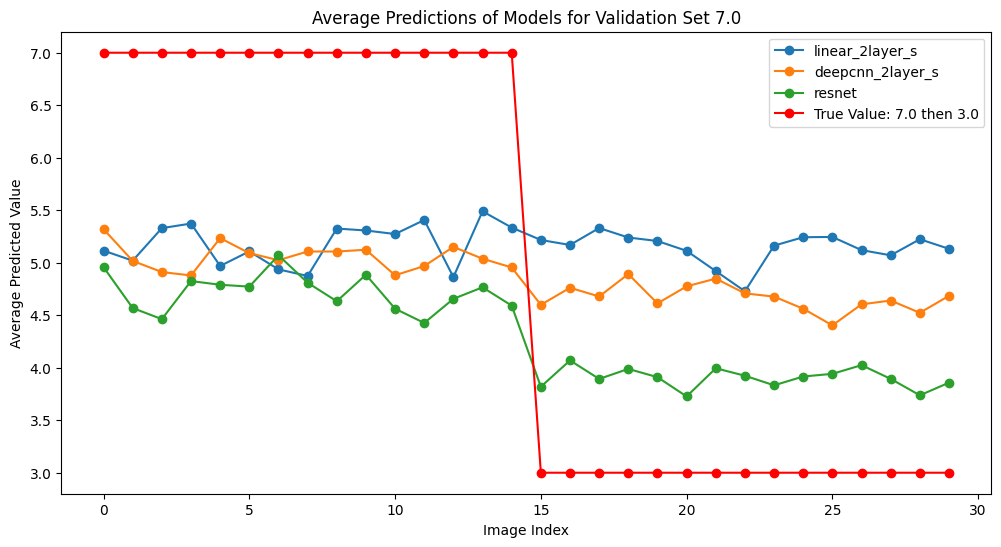

In [59]:
selectedModels = ["linear_2layer_s","deepcnn_2layer_s", "resnet"]
plot_model_predictions_average(models, val_videos, val_labels, chosen_label=7.0,other_label=3.0, sequence_idx=0, selectedModels=selectedModels)

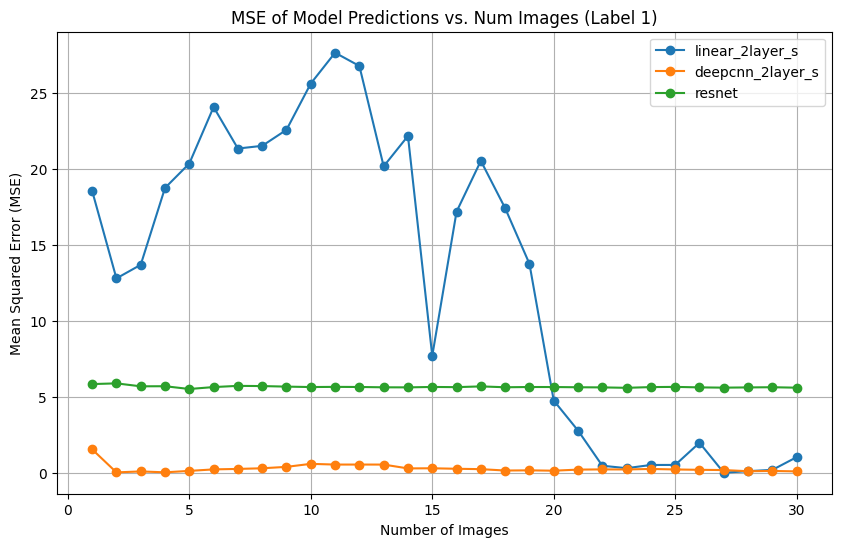

In [43]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_mse_vs_num_images(models, val_videos, val_labels, chosen_label, selectedModels):
    """
    Plots the Mean Squared Error (MSE) of model predictions as a function of num_images.
    
    Args:
    - models (dict): Dictionary of model names and instances.
    - val_videos (tuple): Tuple of validation video tensors.
    - val_labels (Tensor): Corresponding labels (torch.Tensor([1, 3, 5, 7])).
    - chosen_label (int): The validation label to visualize (must be 1, 3, 5, or 7).
    """
    
    # Select only the specified models
    selected_models = {name: model for name, model in models.items() if name in selectedModels}
    
    # Find index of the chosen label
    if chosen_label not in val_labels.tolist():
        print(f"Error: Chosen label {chosen_label} not in available labels {val_labels.tolist()}")
        return
    
    label_idx = val_labels.tolist().index(chosen_label)
    chosen_video = val_videos[label_idx]  # Get corresponding video
    
    num_images_range = range(1, chosen_video.shape[1] + 1)  # Range of num_images
    mse_results = {name: [] for name in selected_models}  # Store MSE results
    
    for num_images in num_images_range:
        input_video = chosen_video[:,:num_images]  # Select subset of images
        for name, model in selected_models.items():
            model.eval()
            with torch.no_grad():

                pred = model(input_video.contiguous()).mean().item()  # Aggregate predictions
                mse = (pred - chosen_label) ** 2  # Compute MSE 
                mse_results[name].append(mse)
    
    # Plot MSE as a function of num_images
    plt.figure(figsize=(10, 6))
    for name, mse_values in mse_results.items():
        plt.plot(num_images_range, mse_values, label=name, marker='o')
    
    plt.xlabel("Number of Images")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title(f"MSE of Model Predictions vs. Num Images (Label {chosen_label})")
    plt.legend()
    plt.grid(True)
    plt.show()
 
plot_mse_vs_num_images(models, val_videos, val_labels, 1, selectedModels)

In [36]:

trajs, labels = models_phenom().single_state(1, 
                            L=0,
                            T=T,
                            Ds=1,  # Mean and variance
                            alphas=1)

trajs = trajs.transpose(1, 0, 2) / (traj_div_factor)
videos = trajectories_to_video(trajs, nPosPerFrame, center=True, image_props=image_props)

play_video(videos[0])

trajs, labels = models_phenom().single_state(7, 
                            L=0,
                            T=T,
                            Ds=7,  # Mean and variance
                            alphas=1)

trajs = trajs.transpose(1, 0, 2) / (traj_div_factor)
videos = trajectories_to_video(trajs, nPosPerFrame, center=True, image_props=image_props)

play_video(videos[0])

vmin: 152.0 vmax: 744.0 mean: 290.30


vmin: 155.0 vmax: 688.0 mean: 290.11


In [32]:
# generate validation trajectories

nPosPerFrame = 10 
# number of time steps per trajectory (frames), will be divided by nPosPerFrame
nFrames = 30
T = nFrames * nPosPerFrame

N = 50 # number of particles
L = 0 # length of the trajectory in pixels

for D in [1,3,5,7]:
    trajs, labels = models_phenom().single_state(N, 
                                    L = L,
                                    T = T,
                                    Ds = [D, 0], # Mean and variance
                                    alphas = 1)
    print(trajs.shape,labels.shape)
    # Need to reshape generated trajectories because they are in format (T,N,dim), but we want them in (N,T,dim)
    trajs = trajs.transpose(1,0,2)
    labels = labels.transpose(1,0,2)
    # Labels are now in format (N,T,3): for each particle T times the tuple (alpha, D, state)
    print(f"Particle 0 [alpha, Gen_D, state]: {labels[0,0,:]}")
    print(f"Particle 1 [alpha, Gen_D, state]: {labels[1,0,:]}")

    np.save(f"./valTrajsSeq/val{D}.npy",trajs)

(300, 50, 2) (300, 50, 3)
Particle 0 [alpha, Gen_D, state]: [1. 1. 2.]
Particle 1 [alpha, Gen_D, state]: [1. 1. 2.]
(300, 50, 2) (300, 50, 3)
Particle 0 [alpha, Gen_D, state]: [1. 3. 2.]
Particle 1 [alpha, Gen_D, state]: [1. 3. 2.]
(300, 50, 2) (300, 50, 3)
Particle 0 [alpha, Gen_D, state]: [1. 5. 2.]
Particle 1 [alpha, Gen_D, state]: [1. 5. 2.]
(300, 50, 2) (300, 50, 3)
Particle 0 [alpha, Gen_D, state]: [1. 7. 2.]
Particle 1 [alpha, Gen_D, state]: [1. 7. 2.]
